In [1]:
import numpy as np
import os
import service.train as train_service

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
# define base data, label store path
old_data_path = os.path.abspath(train_service.old_data_path)
new_data_path = os.path.abspath(train_service.new_data_path)
label_file_name = 'labels.txt'

In [3]:
old_data = train_service.load_gesture_data(old_data_path)
old_actions, old_labels = train_service.load_gesture_label(os.path.join(old_data_path, label_file_name))
new_data = train_service.load_gesture_data(new_data_path)
new_actions, new_labels = train_service.load_gesture_label(os.path.join(new_data_path, label_file_name))

old_actions, old_labels, new_actions, new_labels

(array(['clenching', 'foldIndex', 'foldIndexMiddle', 'away', 'wolf'],
       dtype='<U15'),
 array(['0', '1', '2', '3', '4'], dtype='<U1'),
 array(['touchMiddle'], dtype='<U11'),
 array(['5'], dtype='<U1'))

In [4]:
sample_ratio_value = 0.1
sample_size = int(sample_ratio_value * np.min([len(d) for d in old_data]))
old_sample = train_service.generate_random_sample_from_gesture_list(old_data, sample_size)
old_sample_with_label = train_service.add_label_to_gesture_list(old_sample, old_labels)

new_data_with_label = train_service.add_label_to_gesture_list(np.array(new_data), new_labels)

old_sample_with_label_concat = np.concatenate(old_sample_with_label, axis=0)
new_data_with_label_concat = np.concatenate(new_data_with_label, axis=0)

old_sample_with_label_concat.shape, new_data_with_label_concat.shape

((280, 30, 78), (866, 30, 78))

In [5]:
train_data = np.concatenate([old_sample_with_label_concat, new_data_with_label_concat], axis=0)
train_labels = np.concatenate([old_labels, new_labels])
train_actions = np.concatenate([old_actions, new_actions])

train_data.shape, train_labels, train_actions

((1146, 30, 78),
 array(['0', '1', '2', '3', '4', '5'], dtype='<U1'),
 array(['clenching', 'foldIndex', 'foldIndexMiddle', 'away', 'wolf',
        'touchMiddle'], dtype='<U15'))

In [6]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

x_data = train_data[:, :, :-1]
labels = train_data[:, 0, -1]

y_data = to_categorical(labels, num_classes=len(train_labels))

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=2022)

x_train.shape, y_train.shape, x_val.shape, y_val.shape

((916, 30, 77), (916, 6), (230, 30, 77), (230, 6))

In [7]:
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
save_model_path = 'models/transfer.h5'

model = load_model('models/base_model.h5')
model.pop()
new_output_layer = Dense(len(train_labels), activation='softmax')
model.add(new_output_layer)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 64)                27456     
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 8)                 264       
                                                                 
 dropout_4 (Dropout)         (None, 8)                 0         
                                                                 
 dense (Dense)               (None, 6)                 54        
                                                                 
Total params: 29,854
Trainable params: 29,854
Non-trainable params: 0
_________________________________________________________________


In [8]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=30,
    batch_size=16,
    callbacks=[
        ModelCheckpoint(save_model_path, monitor='val_acc', verbose=1, save_best_oly=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto'),
    ]
)

Epoch 1/30
49/58 [========================>.....] - ETA: 0s - loss: 1.1507 - acc: 0.5931
Epoch 1: saving model to models\transfer.h5
58/58 [==============================] - 2s 12ms/step - loss: 1.1240 - acc: 0.6081 - val_loss: 0.6222 - val_acc: 0.8870 - lr: 0.0010
Epoch 2/30
58/58 [==============================] - ETA: 0s - loss: 0.8737 - acc: 0.7576
Epoch 2: saving model to models\transfer.h5
58/58 [==============================] - 0s 7ms/step - loss: 0.8737 - acc: 0.7576 - val_loss: 0.4919 - val_acc: 0.9174 - lr: 0.0010
Epoch 3/30
57/58 [============================>.] - ETA: 0s - loss: 0.7451 - acc: 0.8092
Epoch 3: saving model to models\transfer.h5
58/58 [==============================] - 0s 7ms/step - loss: 0.7443 - acc: 0.8090 - val_loss: 0.3729 - val_acc: 0.9391 - lr: 0.0010
Epoch 4/30
50/58 [========================>.....] - ETA: 0s - loss: 0.5979 - acc: 0.8450
Epoch 4: saving model to models\transfer.h5
58/58 [==============================] - 0s 7ms/step - loss: 0.5976 - a

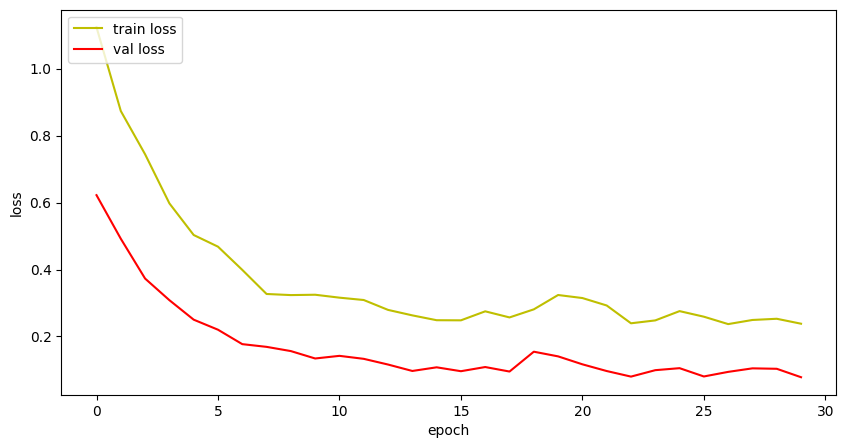

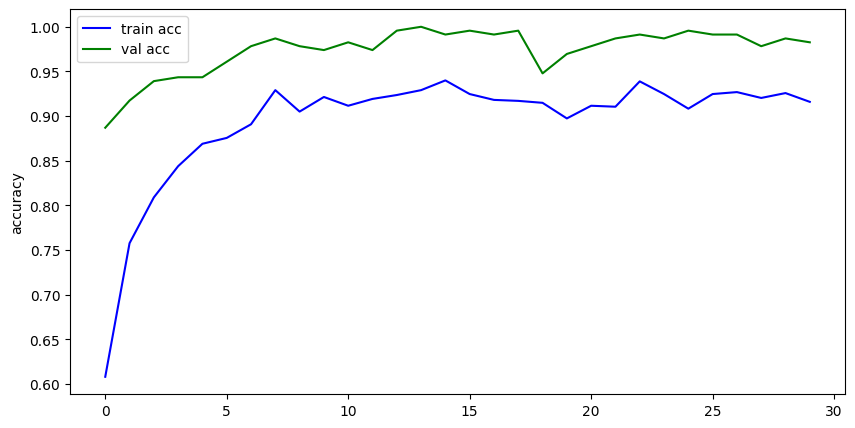

In [9]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(10, 5))

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

fig, acc_ax = plt.subplots(figsize=(10, 5))
acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()